# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [2]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

  Using cached labelme-5.3.1-py3-none-any.whl
  Using cached tensorflow-2.13.0-cp310-cp310-win_amd64.whl (1.9 kB)
  Using cached opencv_python-4.8.0.76-cp37-abi3-win_amd64.whl (38.1 MB)
  Using cached albumentations-1.3.1-py3-none-any.whl (125 kB)
  Using cached imgviz-1.7.4-py3-none-any.whl (7.7 MB)
  Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
  Using cached gdown-4.7.1-py3-none-any.whl (15 kB)
  Using cached onnxruntime-1.15.1-cp310-cp310-win_amd64.whl (6.7 MB)
  Using cached tensorflow_intel-2.13.0-cp310-cp310-win_amd64.whl (276.5 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached protobuf-4.24.2-cp310-abi3-win_amd64.whl (430 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Using cached astunparse-

### 1.2 Collect Images Using OpenCV

In [3]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [10]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Failed to capture image")
        break

    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)

    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [11]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\HP\.labelmerc


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [12]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [13]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [14]:
tf.config.list_physical_devices('GPU')

[]

In [15]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

### 2.3 Load Image into TF Data Pipeline

In [16]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [17]:
images.as_numpy_iterator().next()

b'data\\images\\20103bfa-48c2-11ee-9e36-648099f20485.jpg'

In [18]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images = images.map(load_image)

In [20]:
images.as_numpy_iterator().next()

array([[[106, 103,  84],
        [108, 105,  86],
        [111, 110,  90],
        ...,
        [185, 186, 180],
        [187, 188, 183],
        [187, 187, 185]],

       [[109, 104,  85],
        [109, 106,  87],
        [114, 111,  92],
        ...,
        [184, 185, 177],
        [187, 188, 183],
        [189, 190, 185]],

       [[114, 107,  88],
        [112, 107,  87],
        [114, 109,  89],
        ...,
        [183, 184, 176],
        [188, 189, 183],
        [192, 193, 187]],

       ...,

       [[ 95,  93,  81],
        [ 90,  90,  78],
        [ 88,  88,  78],
        ...,
        [ 83, 102, 116],
        [ 89, 115, 128],
        [ 86, 115, 129]],

       [[ 92,  93,  79],
        [ 89,  91,  77],
        [ 87,  89,  76],
        ...,
        [ 83, 101, 113],
        [ 94, 120, 133],
        [ 92, 121, 135]],

       [[ 91,  93,  79],
        [ 89,  91,  77],
        [ 85,  89,  75],
        ...,
        [ 69,  87,  99],
        [ 87, 113, 126],
        [101, 130, 144]]

In [21]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [22]:
image_generator = images.batch(4).as_numpy_iterator()

In [27]:
plot_images = image_generator.next()

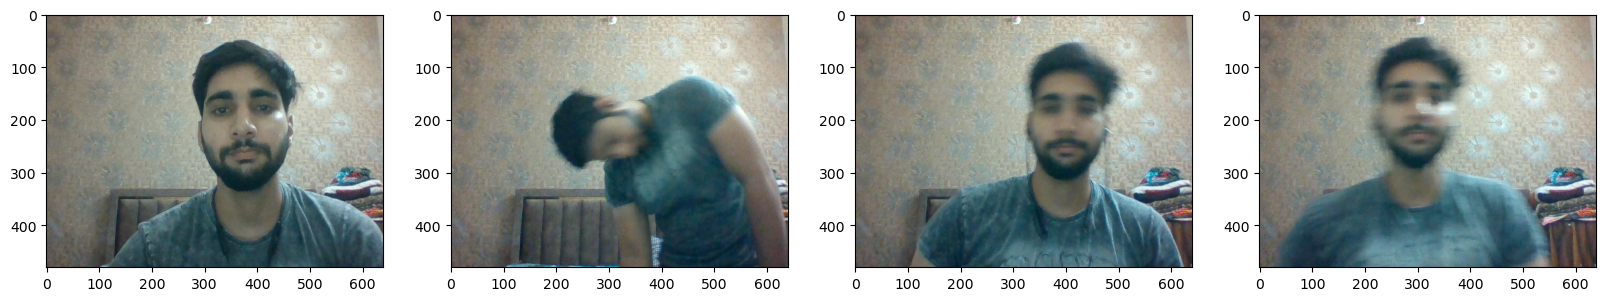

In [28]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [29]:
90*.7 # 63 to train

62.99999999999999

In [30]:
90*.15 # 14 and 13 to test and val

13.5

### 3.2 Move the Matching Labels

In [31]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [32]:
import albumentations as alb

In [33]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [34]:
img = cv2.imread(os.path.join('data','train', 'images','1b41a973-48c2-11ee-8eeb-648099f20485.jpg'))

In [35]:
with open(os.path.join('data', 'train', 'labels', '1b41a973-48c2-11ee-8eeb-648099f20485.json'), 'r') as f:
    label = json.load(f)

In [36]:
label['shapes'][0]['points']

[[263.37016574585635, 2.4309392265193557],
 [386.0220994475138, 94.6961325966851]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [37]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [38]:
coords

[263.37016574585635, 2.4309392265193557, 386.0220994475138, 94.6961325966851]

In [39]:
coords = list(np.divide(coords, [640,480,640,480]))

In [40]:
coords

[0.41151588397790057,
 0.0050644567219153246,
 0.6031595303867403,
 0.1972836095764273]

### 4.4 Apply Augmentations and View Results

In [41]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [42]:
augmented['bboxes'][0][2:]

(0.5902885205647637, 1.0)

In [43]:
augmented['bboxes']

[(0.3177286678944137, 0.8006752608962553, 0.5902885205647637, 1.0)]

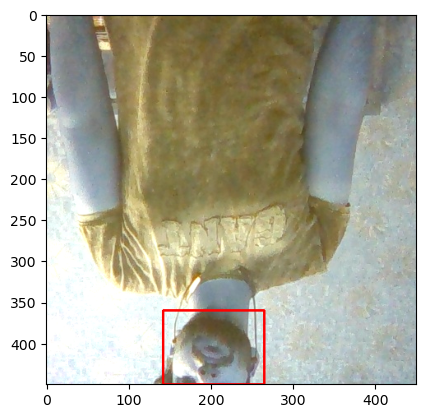

In [44]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [46]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.8500517955801105, 0.27670349907918973, 0.6316470994475137, 0.00046040515653779276, 'face'].
x_max is less than or equal to x_min for bbox [0.6316470994475137, 0.2168508287292818, 0.4287810773480663, 0.00046040515653779276, 'face'].
x_max is less than or equal to x_min for bbox [0.8552313535911603, 0.3975598526703499, 0.5384150552486189, 0.002762430939226559, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [47]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [48]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [49]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [50]:
train_images.as_numpy_iterator().next()

array([[[0.81911767, 0.7382353 , 0.71568626],
        [0.9016544 , 0.85379905, 0.7717525 ],
        [0.8951593 , 0.8625    , 0.78566176],
        ...,
        [0.44791666, 0.42487746, 0.3841912 ],
        [0.39944854, 0.37199754, 0.340625  ],
        [0.37732843, 0.3572304 , 0.31556374]],

       [[0.9035539 , 0.8496324 , 0.8050245 ],
        [0.90447307, 0.8575368 , 0.8106005 ],
        [0.81758577, 0.7778799 , 0.74405634],
        ...,
        [0.4317402 , 0.43265933, 0.39313725],
        [0.4216299 , 0.4074755 , 0.36482844],
        [0.422549  , 0.40018383, 0.35257354]],

       [[0.8612132 , 0.8259191 , 0.7592524 ],
        [0.8528799 , 0.8057598 , 0.7528799 ],
        [0.87193626, 0.8209559 , 0.7905637 ],
        ...,
        [0.4033701 , 0.41513482, 0.37199754],
        [0.4610294 , 0.4697304 , 0.4154412 ],
        [0.40998775, 0.41605392, 0.35821077]],

       ...,

       [[0.26832107, 0.2643995 , 0.28664216],
        [0.24405637, 0.24448529, 0.23621324],
        [0.23774509, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [51]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [52]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.271 , 0.    , 0.5435, 0.1771], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [56]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3600, 3600, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [57]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [58]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [59]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [60]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.5884 , 0.379  , 1.     , 0.967  ],
        [0.2617 , 0.766  , 0.6216 , 1.     ],
        [0.2379 , 0.2632 , 0.756  , 0.99   ],
        [0.0634 , 0.02779, 0.5864 , 0.7817 ],
        [0.727  , 0.1908 , 1.     , 0.637  ],
        [0.6836 , 0.     , 1.     , 0.252  ],
        [0.0977 , 0.1033 , 0.699  , 0.748  ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

### 7.3 View Images and Annotations

In [61]:
data_samples = train.as_numpy_iterator()

In [62]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


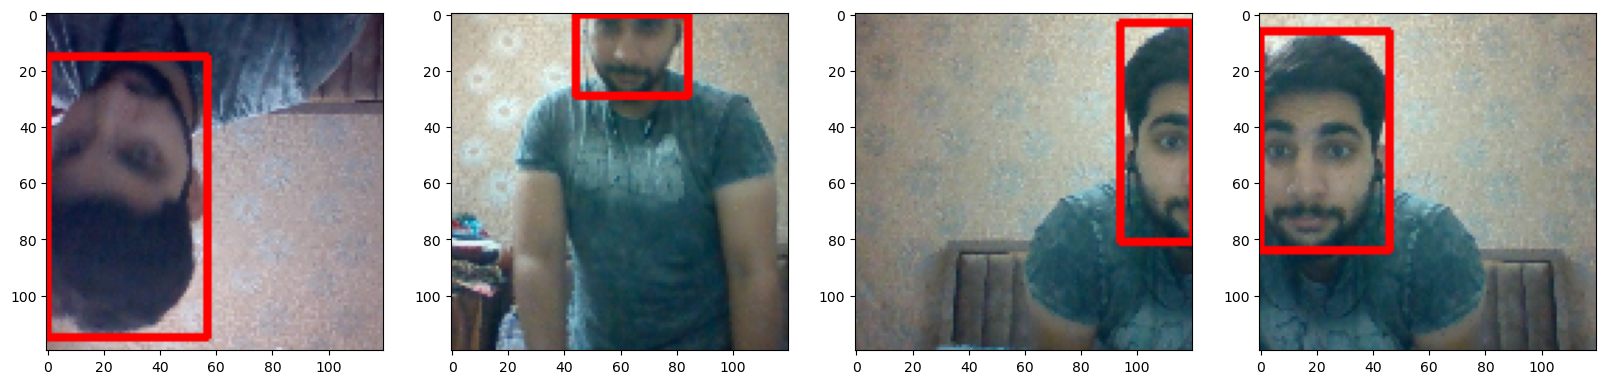

In [63]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [64]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [65]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 69s 1us/step


In [66]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [67]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [68]:
facetracker = build_model()

In [69]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [70]:
X, y = train.as_numpy_iterator().next()

In [71]:
X.shape

(8, 120, 120, 3)

In [72]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 966ms/step


In [73]:
classes, coords

(array([[0.45145053],
        [0.44330338],
        [0.5472173 ],
        [0.49339464],
        [0.41004768],
        [0.41807467],
        [0.4982087 ],
        [0.48542213]], dtype=float32),
 array([[0.4508546 , 0.623184  , 0.6540546 , 0.42492887],
        [0.45098022, 0.61056983, 0.66261137, 0.52831274],
        [0.5264163 , 0.63323724, 0.6231812 , 0.45777658],
        [0.490535  , 0.62275416, 0.60788953, 0.48247033],
        [0.44086432, 0.58813334, 0.6304266 , 0.3806085 ],
        [0.37142774, 0.5625251 , 0.6139086 , 0.46876514],
        [0.4672895 , 0.6343313 , 0.67330104, 0.4690354 ],
        [0.46243048, 0.6515044 , 0.67621195, 0.5168405 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [74]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [76]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [77]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [78]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [79]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.9880404>

In [80]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7626492>

In [81]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.9880404>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [82]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [83]:
model = FaceTracker(facetracker)

In [84]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [85]:
logdir='logs'

In [86]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [87]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
450/450 [==============================] - 2018s 4s/step - total_loss: 0.4127 - class_loss: 0.0869 - regress_loss: 0.3693 - val_total_loss: 0.3013 - val_class_loss: 0.1103 - val_regress_loss: 0.2462
Epoch 2/10
450/450 [==============================] - 1404s 3s/step - total_loss: 0.1009 - class_loss: 0.0253 - regress_loss: 0.0883 - val_total_loss: 0.3613 - val_class_loss: 0.0248 - val_regress_loss: 0.3489
Epoch 3/10
450/450 [==============================] - 1400s 3s/step - total_loss: 0.0677 - class_loss: 0.0169 - regress_loss: 0.0593 - val_total_loss: 0.3161 - val_class_loss: 0.0471 - val_regress_loss: 0.2926
Epoch 4/10
450/450 [==============================] - 1398s 3s/step - total_loss: 0.0504 - class_loss: 0.0119 - regress_loss: 0.0444 - val_total_loss: 0.5727 - val_class_loss: 4.6275e-04 - val_regress_loss: 0.5725
Epoch 5/10
450/450 [==============================] - 3598s 8s/step - total_loss: 0.0454 - class_loss: 0.0090 - regress_loss: 0.0409 - val_total_loss: 0.365

### 10.3 Plot Performance

In [88]:
hist.history

{'total_loss': [0.10330505669116974,
  0.1266539990901947,
  0.14248116314411163,
  0.3944897949695587,
  0.04164863005280495,
  0.008690978400409222,
  0.015060233883559704,
  0.006708300206810236,
  0.09630092978477478,
  0.006089431699365377],
 'class_loss': [0.00031222833786159754,
  0.002036530524492264,
  0.04114855080842972,
  0.21281121671199799,
  0.011223054490983486,
  0.0005702811176888645,
  0.0005490926560014486,
  2.3739123207633384e-05,
  0.02510101906955242,
  0.00010300090070813894],
 'regress_loss': [0.1031489446759224,
  0.12563572824001312,
  0.12190689146518707,
  0.2880841791629791,
  0.036037102341651917,
  0.008405838161706924,
  0.014785687439143658,
  0.006696430500596762,
  0.083750419318676,
  0.006037931423634291],
 'val_total_loss': [0.30128106474876404,
  0.36128804087638855,
  0.31613820791244507,
  0.572748064994812,
  0.3656366765499115,
  0.0418928787112236,
  1.5274004936218262,
  0.051547493785619736,
  0.030752550810575485,
  0.12047369033098221],

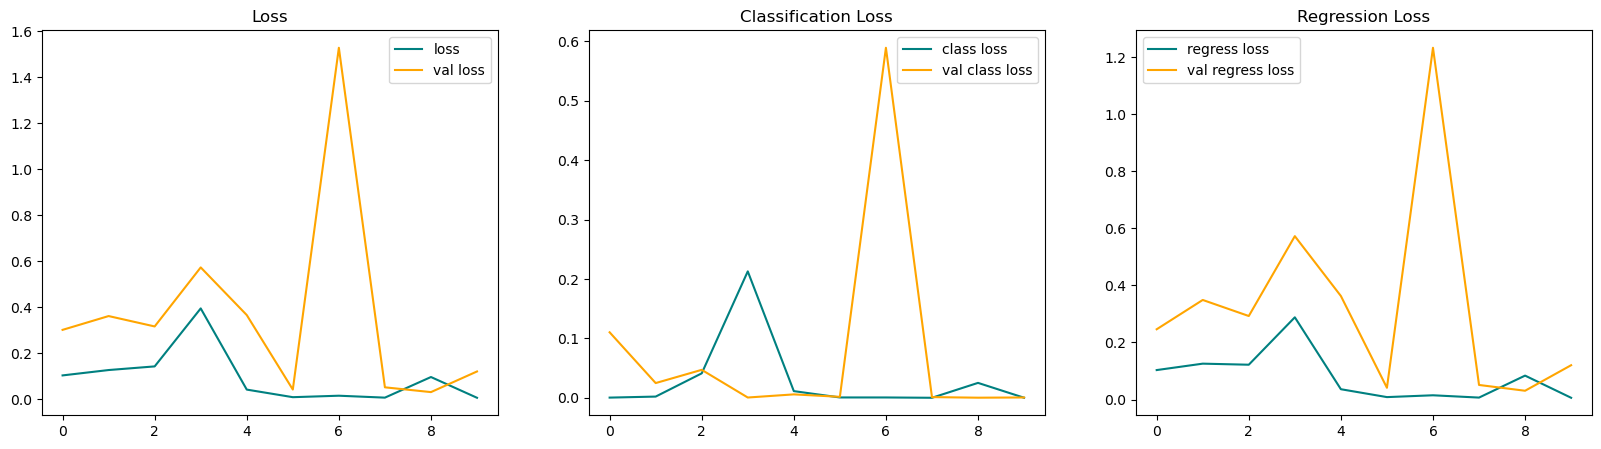

In [89]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [90]:
test_data = test.as_numpy_iterator()

In [91]:
test_sample = test_data.next()

In [92]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 629ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


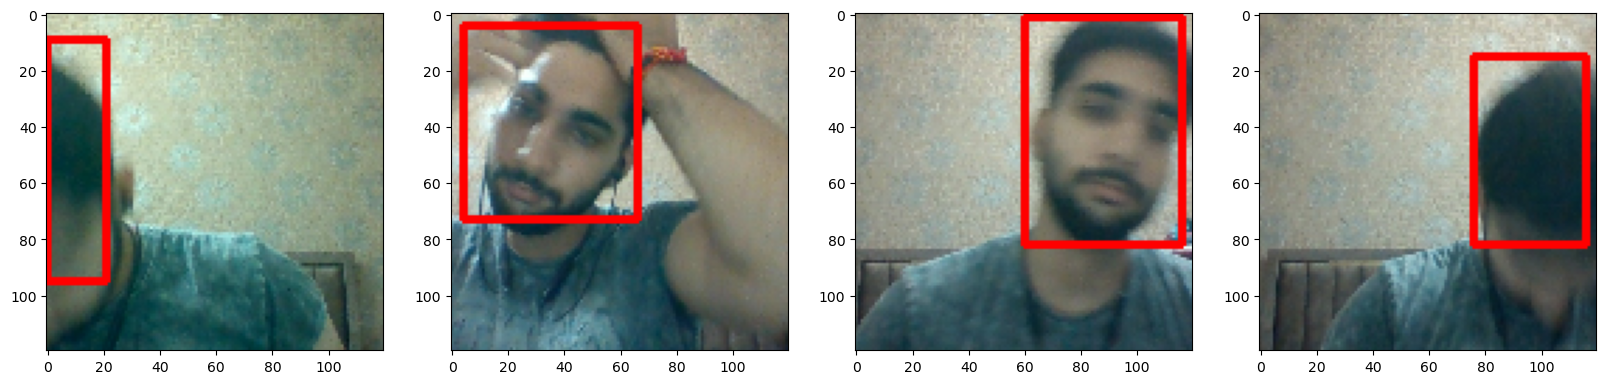

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [94]:
from tensorflow.keras.models import load_model

In [95]:
facetracker.save('facetracker.h5')

C:\Users\HP\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [96]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 112ms/step
